##### Import

In [1]:
import warnings
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.pipeline import Pipeline
import os
import gc
import sys

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from utils import rank_and_quantize

top = 250 # parameters -> papermill

DATA_STORE = Path(f'data/{top}_dataset.h5')
dataset_key = '/data/YEAR_20220906_20230811'
# dataset_key = None

with pd.HDFStore(DATA_STORE) as store:
    dataset = store[dataset_key]
    # dataset = store['/data/YEAR_20161115_20181022']
    dataset = rank_and_quantize(dataset, TARGET_col='TARGET_ret_fwd_frac_order')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 59607 entries, ('AA', Timestamp('2022-09-06 00:00:00')) to ('ZTS', Timestamp('2023-08-11 00:00:00'))
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_frac_order_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 142.6+ MB


In [4]:
# Assuming your DataFrame is named df
cols = dataset.columns.tolist()

# Populate the features list with column names starting with 'feature_'
features = [col for col in cols if col.startswith('FEATURE_')]

# Find the first column starting with 'target_' and set it as the label
label_cols = [col for col in cols if col.startswith('TARGET_')]
# print(label_cols)
# label = label_cols[0] if label_cols else None
label = 'TARGET_ret_fwd_frac_order_quantiled' # parameters
print(len(features))  # This will show all the columns starting with 'feature_'
print(label)  # This will show the first column starting with 'target_'

586
TARGET_ret_fwd_frac_order_quantiled


In [5]:
# Get unique dates and sort them
unique_dates = dataset.index.get_level_values('date').unique().sort_values()

# Adjust for the look-ahead gap
look_ahead = 1

# Split dates for training and testing with a gap
train_dates = unique_dates[:-21-look_ahead]
test_dates = unique_dates[-21:]

# Split the dataset
train_data = dataset.loc[pd.IndexSlice[:, train_dates], :]
test_data = dataset.loc[pd.IndexSlice[:, test_dates], :]

In [6]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                index=model.feature_name()))
                
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], \
        is_higher_better

def sharpe_ratio_lgbm(preds, train_data):
    """Custom Sharpe ratio eval metric for lightgbm that calculates daily Spearman correlations."""
    labels = train_data.get_label()
    
    # Assuming the data index is a MultiIndex with date as the first level
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    # Group by the first level of the MultiIndex (date) and compute the Spearman correlation for each group
    grouped_labels = pd.Series(labels, \
        index=train_data.data.index).groupby(level=0)
    # print(len(grouped_labels))
    grouped_preds = pd.Series(preds, \
        index=train_data.data.index).groupby(level=0)
    # print(len(grouped_preds))

    daily_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        if np.isnan(score_for_day):
            score_for_day = 0
        daily_scores.append(score_for_day)

    # Calculate the Sharpe ratio
    sharpe_ratio = np.mean(daily_scores) / (np.std(daily_scores) + 1e-9)  # added epsilon to avoid division by zero

    return 'sharpe_ratio', sharpe_ratio, True

In [7]:
def metrics_on_fold(era_scores):
    era_scores = pd.Series(era_scores)
    
    # Calculate metrics
    mean_correlation = np.mean(era_scores)
    std_deviation = np.std(era_scores)
    sharpe_ratio = mean_correlation / std_deviation
    max_dd = (era_scores.cummax() - era_scores).max()

    # Smart Sharpe
    smart_sharpe = mean_correlation / (std_deviation + np.std(era_scores.diff()))
    
    # Autocorrelation
    autocorrelation = era_scores.autocorr()

    metrics = pd.Series({
        'mean_correlation': mean_correlation,
        'std_deviation': std_deviation,
        'sharpe_ratio': sharpe_ratio,
        'smart_sharpe': smart_sharpe,
        'autocorrelation': autocorrelation,
        'max_dd': max_dd,
        'min_correlation': era_scores.min(),
        'max_correlation': era_scores.max(),
    })

    # Cleanup
    _ = gc.collect()
    
    return metrics

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 54019 entries, ('AA', Timestamp('2022-09-06 00:00:00')) to ('ZTS', Timestamp('2023-07-12 00:00:00'))
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_frac_order_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 129.3+ MB


In [9]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
import mlflow
import mlflow.lightgbm
from optuna.integration import LightGBMPruningCallback
from scipy.stats import spearmanr
from utils import CustomBackwardMultipleTimeSeriesCV
import warnings

warnings.filterwarnings('ignore')

evals_result = {}

def get_categoricals(dataset, threshold):
    return [col for col in dataset.columns if \
            dataset[col].nunique() < threshold and \
            dataset[col].ge(0).all() and col.startswith("FEATURE_")]

def objective(trial, data, features, cv):
    # Dynamic categoricals based on the trial's suggested threshold
    cat_threshold = trial.suggest_int('cat_threshold', 5, 50)
    categoricals = [col for col in data.columns if data[col].nunique() < cat_threshold 
                    and data[col].ge(0).all() and col.startswith("FEATURE_")]

    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'verbose': -1,
        'metric': 'None',
        'device': 'gpu',
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    early_stopping = lgb.early_stopping(stopping_rounds=500, \
        verbose=True, first_metric_only=True)
    all_daily_scores = []

    for train_idx, val_idx in cv:
        train_features = data.loc[train_idx, features]
        train_labels = data.loc[train_idx, label]
        lgb_train = lgb.Dataset(data=train_features, label=train_labels, 
                                categorical_feature=categoricals, free_raw_data=False)

        val_features = data.loc[val_idx, features]
        val_labels = data.loc[val_idx, label]
        lgb_val = lgb.Dataset(data=val_features, label=val_labels, 
                              categorical_feature=categoricals, free_raw_data=False)

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=5000,
                          valid_sets=[lgb_train, lgb_val],
                          valid_names=['train', 'valid_0'],
                          feval=sharpe_ratio_lgbm,
                          callbacks=[lgb.record_evaluation(evals_result),
                                     early_stopping,
                                     LightGBMPruningCallback(trial, 'sharpe_ratio')])
        
        all_daily_scores.extend(evals_result['valid_0']['sharpe_ratio'])

    metrics = metrics_on_fold(all_daily_scores)
    score = metrics['smart_sharpe']

    # Log parameters and metrics to MLflow
    with mlflow.start_run():
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.log_metric("avg_sharpe_ratio", np.mean(score))
        # mlflow.lightgbm.log_model(model, "lightgbm_model")


    return score if not np.isnan(score) else 1e-9

In [10]:
import os
import optuna

cv = CustomBackwardMultipleTimeSeriesCV(train_data, train_period_length=21*3, 
                                        test_period_length=5, 
                                        lookahead=1, 
                                        date_idx='date')

def progress_bar(study, trial, n_trials):
    progress = (trial.number + 1) / n_trials
    best_trial_msg = ""
    if study.best_trial is not None:
        best_trial_msg = f"Best is trial {study.best_trial.number} \
            with value: {study.best_trial.value}."
    print(f'Trial {trial.number + 1}/{n_trials} finished with value: \
        {trial.value} and parameters: {trial.params}. {best_trial_msg}')

# Check if 'study' directory exists, if not, create it.
if not os.path.exists("study"):
    os.makedirs("study")

# Use SQLite to store optimization results.
# The study results are stored in the "study" folder as "study.db".
storage_name = "sqlite:///study/study.db"

# Name of the study. This should be consistent for resuming the study later.
study_name = "lgbm_optimization"

# Try to load the study. If it doesn't exist, create a new one.
study = optuna.create_study(study_name=study_name,
                            storage=storage_name,
                            direction='maximize',
                            load_if_exists=True, 
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, \
                            n_warmup_steps=5))

n_trials = 15
study.optimize(lambda trial: objective(trial, train_data, features, cv), 
               n_trials=n_trials, 
               callbacks=[lambda study, trial: progress_bar(study, trial, n_trials)])

# Printing the optimization results
print(f'Best trial score: {study.best_trial.value}')
print('Best hyperparameters:')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')

best_params = study.best_params
print("Best parameters found by Optuna:")
print(best_params)

# Remove the study database
os.remove("study/study.db")
print("Database has been deleted.")

[I 2023-09-27 14:54:39,074] A new study created in RDB with name: lgbm_optimization


Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[6]	train's sharpe_ratio: 1.38984	valid_0's sharpe_ratio: 0.129171
Evaluated only: sharpe_ratio
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[7]	train's sharpe_ratio: 1.43337	valid_0's sharpe_ratio: 0.185166
Evaluated only: sharpe_ratio
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[87]	train's sharpe_ratio: 2.31194	valid_0's sharpe_ratio: 0.154704
Evaluated only: sharpe_ratio


[I 2023-09-27 14:57:15,044] Trial 0 finished with value: 1.112326484240215 and parameters: {'cat_threshold': 42, 'num_leaves': 117, 'learning_rate': 0.011601837618214494, 'feature_fraction': 0.794811389453397, 'bagging_fraction': 0.43515193060787927, 'bagging_freq': 6, 'min_child_samples': 71, 'lambda_l1': 0.001146116226549494, 'lambda_l2': 0.09246184737067795}. Best is trial 0 with value: 1.112326484240215.


Trial 1/15 finished with value:         1.112326484240215 and parameters: {'cat_threshold': 42, 'num_leaves': 117, 'learning_rate': 0.011601837618214494, 'feature_fraction': 0.794811389453397, 'bagging_fraction': 0.43515193060787927, 'bagging_freq': 6, 'min_child_samples': 71, 'lambda_l1': 0.001146116226549494, 'lambda_l2': 0.09246184737067795}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:15,582] Trial 1 finished with value: 1e-09 and parameters: {'cat_threshold': 40, 'num_leaves': 32, 'learning_rate': 0.017449364230767785, 'feature_fraction': 0.8889563805645091, 'bagging_fraction': 0.9163637549307545, 'bagging_freq': 7, 'min_child_samples': 19, 'lambda_l1': 0.10294978581345816, 'lambda_l2': 2.566189370226134e-08}. Best is trial 0 with value: 1.112326484240215.


Trial 2/15 finished with value:         1e-09 and parameters: {'cat_threshold': 40, 'num_leaves': 32, 'learning_rate': 0.017449364230767785, 'feature_fraction': 0.8889563805645091, 'bagging_fraction': 0.9163637549307545, 'bagging_freq': 7, 'min_child_samples': 19, 'lambda_l1': 0.10294978581345816, 'lambda_l2': 2.566189370226134e-08}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:16,132] Trial 2 finished with value: 1e-09 and parameters: {'cat_threshold': 6, 'num_leaves': 113, 'learning_rate': 0.015087876318747539, 'feature_fraction': 0.48050675963567335, 'bagging_fraction': 0.6392878355489717, 'bagging_freq': 2, 'min_child_samples': 35, 'lambda_l1': 0.00021456564601291038, 'lambda_l2': 0.014608949949262142}. Best is trial 0 with value: 1.112326484240215.


Trial 3/15 finished with value:         1e-09 and parameters: {'cat_threshold': 6, 'num_leaves': 113, 'learning_rate': 0.015087876318747539, 'feature_fraction': 0.48050675963567335, 'bagging_fraction': 0.6392878355489717, 'bagging_freq': 2, 'min_child_samples': 35, 'lambda_l1': 0.00021456564601291038, 'lambda_l2': 0.014608949949262142}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:16,717] Trial 3 finished with value: 1e-09 and parameters: {'cat_threshold': 19, 'num_leaves': 57, 'learning_rate': 0.05178782402768964, 'feature_fraction': 0.6141405976415555, 'bagging_fraction': 0.6506644345137864, 'bagging_freq': 4, 'min_child_samples': 40, 'lambda_l1': 1.987738208143565, 'lambda_l2': 0.6359955212494647}. Best is trial 0 with value: 1.112326484240215.


Trial 4/15 finished with value:         1e-09 and parameters: {'cat_threshold': 19, 'num_leaves': 57, 'learning_rate': 0.05178782402768964, 'feature_fraction': 0.6141405976415555, 'bagging_fraction': 0.6506644345137864, 'bagging_freq': 4, 'min_child_samples': 40, 'lambda_l1': 1.987738208143565, 'lambda_l2': 0.6359955212494647}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:17,291] Trial 4 finished with value: 1e-09 and parameters: {'cat_threshold': 20, 'num_leaves': 36, 'learning_rate': 0.0026350644267553944, 'feature_fraction': 0.6776546960602838, 'bagging_fraction': 0.6533476856901743, 'bagging_freq': 4, 'min_child_samples': 27, 'lambda_l1': 0.0034111620260814045, 'lambda_l2': 4.953312950493693e-05}. Best is trial 0 with value: 1.112326484240215.


Trial 5/15 finished with value:         1e-09 and parameters: {'cat_threshold': 20, 'num_leaves': 36, 'learning_rate': 0.0026350644267553944, 'feature_fraction': 0.6776546960602838, 'bagging_fraction': 0.6533476856901743, 'bagging_freq': 4, 'min_child_samples': 27, 'lambda_l1': 0.0034111620260814045, 'lambda_l2': 4.953312950493693e-05}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:17,847] Trial 5 finished with value: 1e-09 and parameters: {'cat_threshold': 41, 'num_leaves': 94, 'learning_rate': 0.0012797519223814546, 'feature_fraction': 0.7061047022683897, 'bagging_fraction': 0.4273994813004329, 'bagging_freq': 5, 'min_child_samples': 100, 'lambda_l1': 3.1700824459737604, 'lambda_l2': 0.00015334486389150374}. Best is trial 0 with value: 1.112326484240215.


Trial 6/15 finished with value:         1e-09 and parameters: {'cat_threshold': 41, 'num_leaves': 94, 'learning_rate': 0.0012797519223814546, 'feature_fraction': 0.7061047022683897, 'bagging_fraction': 0.4273994813004329, 'bagging_freq': 5, 'min_child_samples': 100, 'lambda_l1': 3.1700824459737604, 'lambda_l2': 0.00015334486389150374}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:18,396] Trial 6 finished with value: 1e-09 and parameters: {'cat_threshold': 12, 'num_leaves': 35, 'learning_rate': 0.0076019780399367055, 'feature_fraction': 0.5386296675252227, 'bagging_fraction': 0.47283056155660397, 'bagging_freq': 1, 'min_child_samples': 53, 'lambda_l1': 0.000676800043455085, 'lambda_l2': 1.435920070880093}. Best is trial 0 with value: 1.112326484240215.


Trial 7/15 finished with value:         1e-09 and parameters: {'cat_threshold': 12, 'num_leaves': 35, 'learning_rate': 0.0076019780399367055, 'feature_fraction': 0.5386296675252227, 'bagging_fraction': 0.47283056155660397, 'bagging_freq': 1, 'min_child_samples': 53, 'lambda_l1': 0.000676800043455085, 'lambda_l2': 1.435920070880093}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:18,963] Trial 7 finished with value: 1e-09 and parameters: {'cat_threshold': 22, 'num_leaves': 125, 'learning_rate': 0.012008768503559841, 'feature_fraction': 0.8858459763749604, 'bagging_fraction': 0.952894378702605, 'bagging_freq': 5, 'min_child_samples': 67, 'lambda_l1': 0.19189548423197064, 'lambda_l2': 2.3952800579789746e-07}. Best is trial 0 with value: 1.112326484240215.


Trial 8/15 finished with value:         1e-09 and parameters: {'cat_threshold': 22, 'num_leaves': 125, 'learning_rate': 0.012008768503559841, 'feature_fraction': 0.8858459763749604, 'bagging_fraction': 0.952894378702605, 'bagging_freq': 5, 'min_child_samples': 67, 'lambda_l1': 0.19189548423197064, 'lambda_l2': 2.3952800579789746e-07}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:19,513] Trial 8 finished with value: 1e-09 and parameters: {'cat_threshold': 17, 'num_leaves': 88, 'learning_rate': 0.013860053389229627, 'feature_fraction': 0.525605072022108, 'bagging_fraction': 0.8907664447360388, 'bagging_freq': 4, 'min_child_samples': 9, 'lambda_l1': 1.141326391094302, 'lambda_l2': 0.07131360106785442}. Best is trial 0 with value: 1.112326484240215.


Trial 9/15 finished with value:         1e-09 and parameters: {'cat_threshold': 17, 'num_leaves': 88, 'learning_rate': 0.013860053389229627, 'feature_fraction': 0.525605072022108, 'bagging_fraction': 0.8907664447360388, 'bagging_freq': 4, 'min_child_samples': 9, 'lambda_l1': 1.141326391094302, 'lambda_l2': 0.07131360106785442}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:20,080] Trial 9 finished with value: 1e-09 and parameters: {'cat_threshold': 14, 'num_leaves': 47, 'learning_rate': 0.03355655124949303, 'feature_fraction': 0.8947877487919285, 'bagging_fraction': 0.6792709955324308, 'bagging_freq': 5, 'min_child_samples': 77, 'lambda_l1': 0.0001397035467430649, 'lambda_l2': 1.1733186242202624e-07}. Best is trial 0 with value: 1.112326484240215.


Trial 10/15 finished with value:         1e-09 and parameters: {'cat_threshold': 14, 'num_leaves': 47, 'learning_rate': 0.03355655124949303, 'feature_fraction': 0.8947877487919285, 'bagging_fraction': 0.6792709955324308, 'bagging_freq': 5, 'min_child_samples': 77, 'lambda_l1': 0.0001397035467430649, 'lambda_l2': 1.1733186242202624e-07}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:20,647] Trial 10 finished with value: 1e-09 and parameters: {'cat_threshold': 48, 'num_leaves': 146, 'learning_rate': 0.08870539086866312, 'feature_fraction': 0.9933098210254458, 'bagging_fraction': 0.5192026681118007, 'bagging_freq': 7, 'min_child_samples': 98, 'lambda_l1': 1.6416159939413661e-06, 'lambda_l2': 7.598441067277349}. Best is trial 0 with value: 1.112326484240215.


Trial 11/15 finished with value:         1e-09 and parameters: {'cat_threshold': 48, 'num_leaves': 146, 'learning_rate': 0.08870539086866312, 'feature_fraction': 0.9933098210254458, 'bagging_fraction': 0.5192026681118007, 'bagging_freq': 7, 'min_child_samples': 98, 'lambda_l1': 1.6416159939413661e-06, 'lambda_l2': 7.598441067277349}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:21,234] Trial 11 finished with value: 1e-09 and parameters: {'cat_threshold': 35, 'num_leaves': 78, 'learning_rate': 0.005786654189736129, 'feature_fraction': 0.8015035067903686, 'bagging_fraction': 0.8492480928616767, 'bagging_freq': 7, 'min_child_samples': 7, 'lambda_l1': 0.02837472496478418, 'lambda_l2': 2.737067159766585e-08}. Best is trial 0 with value: 1.112326484240215.


Trial 12/15 finished with value:         1e-09 and parameters: {'cat_threshold': 35, 'num_leaves': 78, 'learning_rate': 0.005786654189736129, 'feature_fraction': 0.8015035067903686, 'bagging_fraction': 0.8492480928616767, 'bagging_freq': 7, 'min_child_samples': 7, 'lambda_l1': 0.02837472496478418, 'lambda_l2': 2.737067159766585e-08}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:21,802] Trial 12 finished with value: 1e-09 and parameters: {'cat_threshold': 33, 'num_leaves': 114, 'learning_rate': 0.024390729127871123, 'feature_fraction': 0.7765361937987246, 'bagging_fraction': 0.767668027405674, 'bagging_freq': 7, 'min_child_samples': 74, 'lambda_l1': 0.019847576105561853, 'lambda_l2': 6.6495834851580715e-06}. Best is trial 0 with value: 1.112326484240215.


Trial 13/15 finished with value:         1e-09 and parameters: {'cat_threshold': 33, 'num_leaves': 114, 'learning_rate': 0.024390729127871123, 'feature_fraction': 0.7765361937987246, 'bagging_fraction': 0.767668027405674, 'bagging_freq': 7, 'min_child_samples': 74, 'lambda_l1': 0.019847576105561853, 'lambda_l2': 6.6495834851580715e-06}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:22,366] Trial 13 finished with value: 1e-09 and parameters: {'cat_threshold': 49, 'num_leaves': 63, 'learning_rate': 0.005092227511317214, 'feature_fraction': 0.4013967500017565, 'bagging_fraction': 0.5710418589265563, 'bagging_freq': 6, 'min_child_samples': 57, 'lambda_l1': 2.332004775677558e-08, 'lambda_l2': 0.005002689626346325}. Best is trial 0 with value: 1.112326484240215.


Trial 14/15 finished with value:         1e-09 and parameters: {'cat_threshold': 49, 'num_leaves': 63, 'learning_rate': 0.005092227511317214, 'feature_fraction': 0.4013967500017565, 'bagging_fraction': 0.5710418589265563, 'bagging_freq': 6, 'min_child_samples': 57, 'lambda_l1': 2.332004775677558e-08, 'lambda_l2': 0.005002689626346325}. Best is trial 0             with value: 1.112326484240215.


[I 2023-09-27 14:57:22,938] Trial 14 finished with value: 1e-09 and parameters: {'cat_threshold': 41, 'num_leaves': 146, 'learning_rate': 0.022923300641265836, 'feature_fraction': 0.8290801576661282, 'bagging_fraction': 0.7482547122867393, 'bagging_freq': 6, 'min_child_samples': 22, 'lambda_l1': 0.15340465300654493, 'lambda_l2': 2.800758254894711e-06}. Best is trial 0 with value: 1.112326484240215.


Trial 15/15 finished with value:         1e-09 and parameters: {'cat_threshold': 41, 'num_leaves': 146, 'learning_rate': 0.022923300641265836, 'feature_fraction': 0.8290801576661282, 'bagging_fraction': 0.7482547122867393, 'bagging_freq': 6, 'min_child_samples': 22, 'lambda_l1': 0.15340465300654493, 'lambda_l2': 2.800758254894711e-06}. Best is trial 0             with value: 1.112326484240215.
Best trial score: 1.112326484240215
Best hyperparameters:
cat_threshold: 42
num_leaves: 117
learning_rate: 0.011601837618214494
feature_fraction: 0.794811389453397
bagging_fraction: 0.43515193060787927
bagging_freq: 6
min_child_samples: 71
lambda_l1: 0.001146116226549494
lambda_l2: 0.09246184737067795
Best parameters found by Optuna:
{'cat_threshold': 42, 'num_leaves': 117, 'learning_rate': 0.011601837618214494, 'feature_fraction': 0.794811389453397, 'bagging_fraction': 0.43515193060787927, 'bagging_freq': 6, 'min_child_samples': 71, 'lambda_l1': 0.001146116226549494, 'lambda_l2': 0.0924618473706

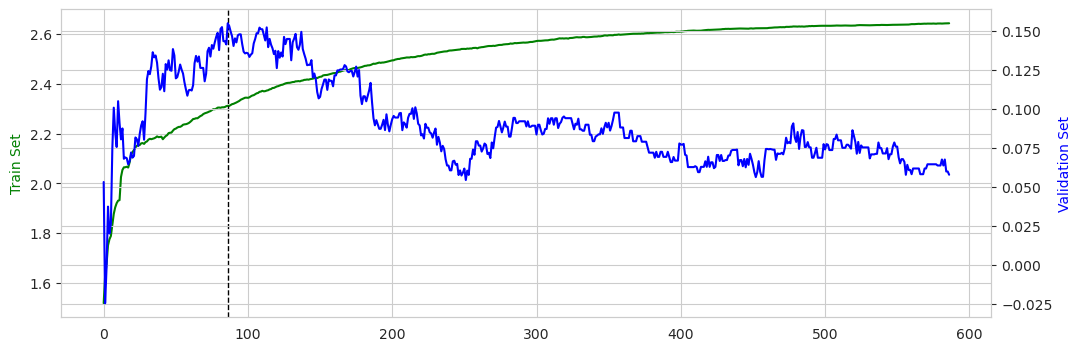

In [11]:
import matplotlib.pyplot as plt

# Create DataFrame from results
cv_result = pd.DataFrame({'Train Set': evals_result['train']['sharpe_ratio'], 
                          'Validation Set': evals_result['valid_0']['sharpe_ratio']})

# Create the plot with separate y-axes for Train and Validation sets
fig, ax1 = plt.subplots(figsize=(12, 4))

ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
ax1.plot(cv_result.index, cv_result['Train Set'], 'g-')
ax2.plot(cv_result.index, cv_result['Validation Set'], 'b-')

ax1.set_ylabel('Train Set', color='g')
ax2.set_ylabel('Validation Set', color='b')
ax1.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)

plt.show()

In [12]:
# # Extract cat_threshold from best_params
# cat_threshold = best_params.get('cat_threshold', 50)  # default to 50 if not in best_params

# Extract cat_threshold from best_params
cat_threshold = best_params.pop('cat_threshold', 50)  # default to 50 if not in best_params


# Determine the categorical columns based on cat_threshold
categoricals = [col for col in train_data.columns if train_data[col].nunique() < cat_threshold 
                and train_data[col].ge(0).all() and col.startswith("FEATURE_")]

# Create the training dataset
lgb_train_all = lgb.Dataset(data=train_data[features], label=train_data[label], 
                            categorical_feature=categoricals, free_raw_data=False)

best_params['force_col_wise'] = True
# Train the model with the best parameters
# best_model = lgb.train(params=best_params,
#                        train_set=lgb_train_all,
#                        num_boost_round=5000,  # or some other number of boosting rounds
#                        feval=sharpe_ratio_lgbm,
#                        callbacks=[lgb.record_evaluation(evals_result)])
best_model = lgb.train(params=best_params,
                       train_set=lgb_train_all,
                       num_boost_round=5000,  # or some other number of boosting rounds
                       feval=sharpe_ratio_lgbm,
                       callbacks=[lgb.record_evaluation(evals_result)])

[LightGBM] [Info] Total Bins 95665
[LightGBM] [Info] Number of data points in the train set: 54019, number of used features: 531
[LightGBM] [Info] Start training from score 0.501754


In [13]:
from pathlib import Path

# Define the models folder path
models = Path("./models")

# Ensure the folder exists
models.mkdir(exist_ok=True)

# Ensure that dataset_key doesn't contain invalid characters like slashes
clean_dataset_key = dataset_key.replace("/", "_")

# Formulate the clean save path
save_path = models / f"{clean_dataset_key}_best_model.txt"

# Try saving again
best_model.save_model(save_path)
print(f"Model saved to {save_path}")

Model saved to models/_data_YEAR_20220906_20230811_best_model.txt


#### Test on unseen data

In [14]:
test_features = test_data[features]
test_labels = test_data[label]

y_pred = best_model.predict(test_features)

preds = test_labels.reset_index(name=\
    'actual').assign(predicted=y_pred).set_index(['date', 'ticker'])

# Rename columns to add 'feature_' prefix
cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
new_col_names = ["FEATURE_" + col for col in cols_to_rename]
rename_dict = dict(zip(cols_to_rename, new_col_names))

test_data_renamed = test_data.rename(columns=rename_dict)

# Using the 'merge' method to join on MultiIndex levels 'date' and 'ticker'
preds = preds.reset_index().merge(test_data_renamed[new_col_names].reset_index(), 
                                  on=['ticker', 'date'], 
                                  how='left')

### Only select columns of interest
preds = preds[['date', 'ticker', 'actual', 'predicted'] \
    + new_col_names].set_index(['ticker', 'date'])


In [15]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [16]:
# Calculate the mean and standard deviation of daily correlations
mean_daily_correlation = daily_correlations.mean()
std_daily_correlation = daily_correlations.std()

# Calculate Sharpe ratio for each date
papermill_era_scores = daily_sharpe_ratios = (daily_correlations - \
    mean_daily_correlation) / std_daily_correlation

papermill_era_scores_df = papermill_era_scores.to_frame()
papermill_era_scores_df.columns = papermill_era_scores_df.columns.astype(str)
sb.glue("papermill_era_scores", papermill_era_scores_df, display=True)

# papermill_era_scores_list = papermill_era_scores.tolist()
# sb.glue("papermill_era_scores", papermill_era_scores_list)


,0
date,
2023-07-14,0.454585
2023-07-17,0.257148
2023-07-18,0.796495
2023-07-19,-1.608293
2023-07-20,0.588957
2023-07-21,0.206217
2023-07-24,-0.016613
2023-07-25,-0.250991
2023-07-26,-1.291273


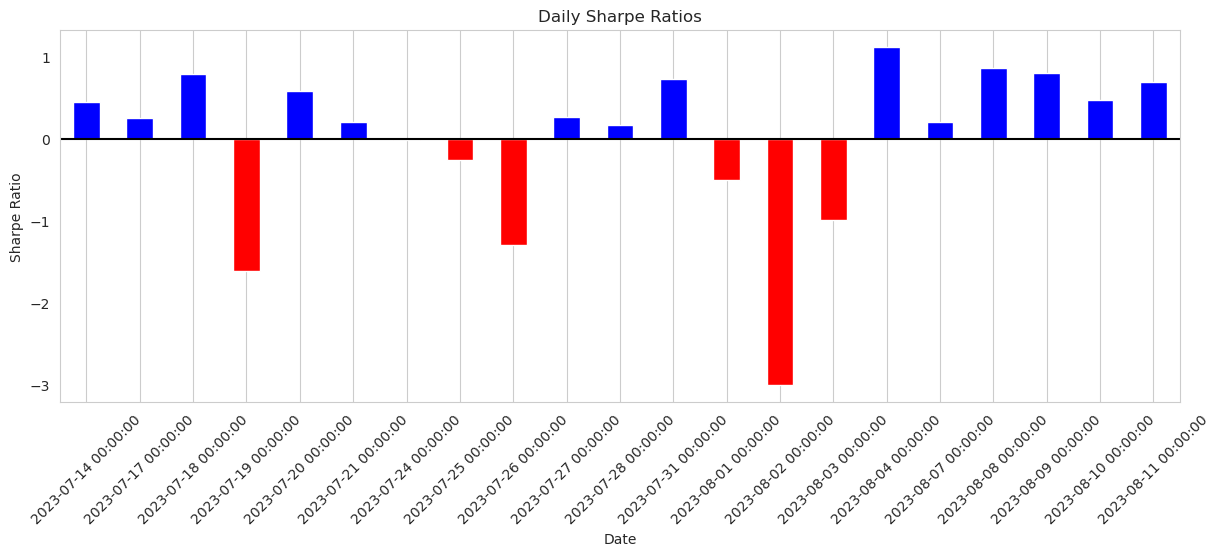

In [17]:
import matplotlib.pyplot as plt

# Create a list of colors based on the sign of the Sharpe Ratios
colors = ['blue' if value > 0 else 'red' for value in daily_sharpe_ratios]

plt.figure(figsize=(12,6))
daily_sharpe_ratios.plot(kind='bar', color=colors)
plt.title('Daily Sharpe Ratios')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y')
plt.tight_layout()
plt.axhline(y=0, color='black', linestyle='-')  # Here's where we add the horizontal line at y=0
plt.xticks(rotation=45)  # rotates the x-axis labels for better visibility
plt.show()

In [18]:
plot_dir = Path("plots")
plot_dir.mkdir(exist_ok=True)
plot_path = plot_dir / f"sharpe_ratios_{key}.png"
plt.savefig(plot_path)
plt.close()

papermill_plot_path_str = str(plot_path)  # Convert to string
sb.glue("papermill_plot_path", papermill_plot_path_str, display=True)  # Glue the string

'plots/sharpe_ratios_lambda_l2.png'

In [19]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

Information Coefficient (overall): 96.113% (p-value: 0.00000000%)


0.9611308464296562

0.0

In [20]:
# papermill_plot_path_str = str(plot_path)  # Convert to string
# sb.glue("papermill_plot_path", papermill_plot_path_str)  # Glue the string

# sb.glue("information_coefficient", information_coefficient)
# sb.glue("p_value", p_value)